In [4]:
! pip install vaderSentiment


   ---------------------------------------- 0.0/126.0 kB ? eta -:--:--
   ------------ -------------------------- 41.0/126.0 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 126.0/126.0 kB 1.5 MB/s eta 0:00:00


In [5]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [7]:
df = pd.read_csv('reviews_data.csv')
df.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [8]:
sb_review = df[['Rating', 'Review']]
sb_review.head()

,Rating,Review
0,5.0,Amber and LaDonna at the Starbucks on Southwes...
1,5.0,** at the Starbucks by the fire station on 436...
2,5.0,I just wanted to go out of my way to recognize...
3,5.0,Me and my friend were at Starbucks and my card...
4,5.0,I’m on this kick of drinking 5 cups of warm wa...


In [9]:
sb_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rating  705 non-null    float64
 1   Review  850 non-null    object 
dtypes: float64(1), object(1)
memory usage: 13.4+ KB


In [10]:
sb_review.isnull().sum()

Rating    145
Review      0
dtype: int64

In [11]:
sb_review.describe()

,Rating
count,705.000000
mean,1.870922
std,1.397672
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,5.000000


In [12]:
sb_review.nunique()

Rating      5
Review    814
dtype: int64

In [13]:
sb_review.dropna(inplace=True)

C:\Users\91776\AppData\Local\Temp\ipykernel_23960\2648812059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sb_review.dropna(inplace=True)


In [14]:
sb_review.isnull().sum()

Rating    0
Review    0
dtype: int64

In [15]:
sb_review['Rating'].value_counts()

1.0    451
2.0     99
5.0     83
4.0     39
3.0     33
Name: Rating, dtype: int64

In [16]:
sb_review.head()

,Rating,Review
0,5.0,Amber and LaDonna at the Starbucks on Southwes...
1,5.0,** at the Starbucks by the fire station on 436...
2,5.0,I just wanted to go out of my way to recognize...
3,5.0,Me and my friend were at Starbucks and my card...
4,5.0,I’m on this kick of drinking 5 cups of warm wa...


In [17]:
df = sb_review.copy()
df

,Rating,Review
0,5.0,Amber and LaDonna at the Starbucks on Southwes...
1,5.0,** at the Starbucks by the fire station on 436...
2,5.0,I just wanted to go out of my way to recognize...
3,5.0,Me and my friend were at Starbucks and my card...
4,5.0,I’m on this kick of drinking 5 cups of warm wa...
...,...,...
700,1.0,I ordered Via Starbucks coffee online. I recei...
701,3.0,"My name is Ric **, I am journalist by professi..."
702,1.0,"The bagel was ice cold, not cut and not toasted."
703,1.0,"In the morning of Monday, August 15, 2011, at ..."


In [18]:
# This function returns Rating value based on:
# Rating <  2.0 -> Negative
# Rating Between 2 and 3 -> Neutral
# Rating > 3.0 -> Positive


def conv(row):
    
    if row['Rating'] < 2.0:
        val = 'Negative'
    elif row['Rating'] > 3.0:
        val = 'Positive'
    else: 
        val = 'Neutral'
    
    return val

In [19]:
df['Rating'] = df.apply(conv, axis=1)
df

,Rating,Review
0,Positive,Amber and LaDonna at the Starbucks on Southwes...
1,Positive,** at the Starbucks by the fire station on 436...
2,Positive,I just wanted to go out of my way to recognize...
3,Positive,Me and my friend were at Starbucks and my card...
4,Positive,I’m on this kick of drinking 5 cups of warm wa...
...,...,...
700,Negative,I ordered Via Starbucks coffee online. I recei...
701,Neutral,"My name is Ric **, I am journalist by professi..."
702,Negative,"The bagel was ice cold, not cut and not toasted."
703,Negative,"In the morning of Monday, August 15, 2011, at ..."


## EDA

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt  
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [23]:
# Rating Distribution

rating_counts = df['Rating'].value_counts().sort_index()

rating_labels = ['Negative', 'Neutral', 'Positive']
rating_colors = ['red', 'yellow', 'blue']

fig = go.Figure(data=[go.Pie(labels=rating_counts.index, 
                             values=rating_counts.values,
                             textinfo='percent+value+label',
                             marker_colors=rating_colors,
                             textposition='auto',
                             hole=.3)])


fig.update_layout(
    title_text='Rating Distribution',
    template='plotly_white',
    xaxis=dict(
        title='Sources',
    ),
    yaxis=dict(
        title='Number of Posts in Twitter',
    )
)

fig.update_traces(marker_line_color='black', 
                  marker_line_width=1.5, 
                  opacity=0.8)
 
fig.show()

**Some required function for preprocessing**

**get_all_string**: this function returns all strings in one sentence given a text series

**get_word**: this function returns list of words given a sentence

**remove_stopword**: this function removes stopwords like "the", "is", "and", and etc

**lemmatize_word**: this function lemmatizes the word (i.e. "Caring" --> "Care")

**create_freq_df**: this function returns the frequency dataframe given the list of words

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91776\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [34]:
def get_all_string(sentences): 
    sentence = ''
    for words in sentences:
        sentence += words
    sentence = re.sub('[^A-Za-z0-9 ]+', '', sentence)
    sentence = re.sub(r'http\S+', '', sentence)
    sentence = sentence.lower()
    return sentence 

def get_word(sentence):
    return nltk.RegexpTokenizer(r'\w+').tokenize(sentence)
def remove_stopword(word_tokens):
    stopword_list = stopwords.words('english')
    filtered_tokens = []
    
    for word in word_tokens:
        if word not in stopword_list: 
            filtered_tokens.append(word) 
    return filtered_tokens 

def lemmatize_words(filtered_tokens):
    lemm = WordNetLemmatizer() 
    cleaned_tokens = [lemm.lemmatize(word) for word in filtered_tokens]
    return cleaned_tokens

def create_freq_df(cleaned_tokens): 
    fdist = nltk.FreqDist(cleaned_tokens)
    freq_df = pd.DataFrame.from_dict(fdist, orient='index')
    freq_df.columns = ['Frequency']
    freq_df.index.name = 'Term'
    freq_df = freq_df.sort_values(by=['Frequency'], ascending=False)
    freq_df = freq_df.reset_index()
    return freq_df

def preprocess(series):
    all_string = get_all_string(series)
    words = get_word(all_string)
    cleaned_tokens = remove_stopword(words)
    return cleaned_tokens


In [35]:
def plot_text_distribution(x_df, y_df, color, title, xaxis_text, yaxis_text):
    
    fig = px.bar(x=x_df, 
                y=y_df,
                color=y_df,
                text=y_df,
                color_continuous_scale=color)

    fig.update_layout(
        title_text=title,
        template='plotly_white',
        xaxis=dict(
            title=xaxis_text,
        ),
        yaxis=dict(
            title=yaxis_text,
        )
    )

    fig.update_traces(marker_line_color='black', 
                    marker_line_width=1.5, 
                    opacity=0.8)
    
    fig.show()


In [36]:
def create_wordcloud(freq_df, title, color):
    
    data = freq_df.set_index('Term').to_dict()['Frequency']
    
    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800, 
               height=400, 
               max_words=100,
               colormap= color,
               max_font_size=200,
               min_font_size = 1 ,
               random_state=8888, 
               background_color='white').generate_from_frequencies(data)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

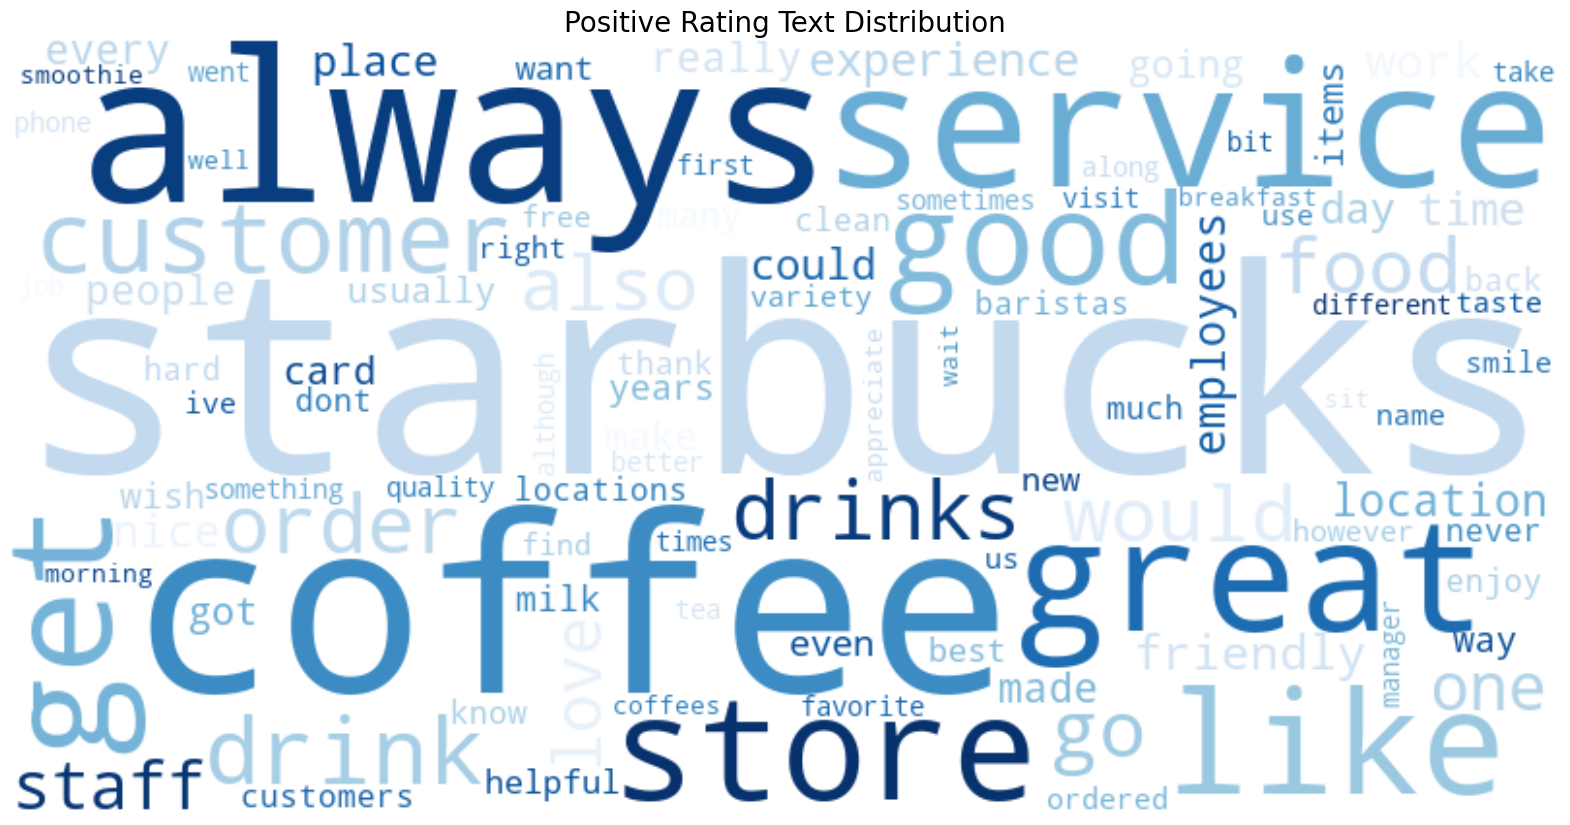

In [37]:
# Positive Words
import re
positive_words = preprocess(df.loc[df['Rating'] == 'Positive']['Review'])
positive_words_df = create_freq_df(positive_words)
top10_positive_words = positive_words_df[:10]

plot_text_distribution(top10_positive_words['Term'], top10_positive_words['Frequency'],
                  'blues', 'Top 10 Positive Rating Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(positive_words_df, 'Positive Rating Text Distribution', 'Blues')

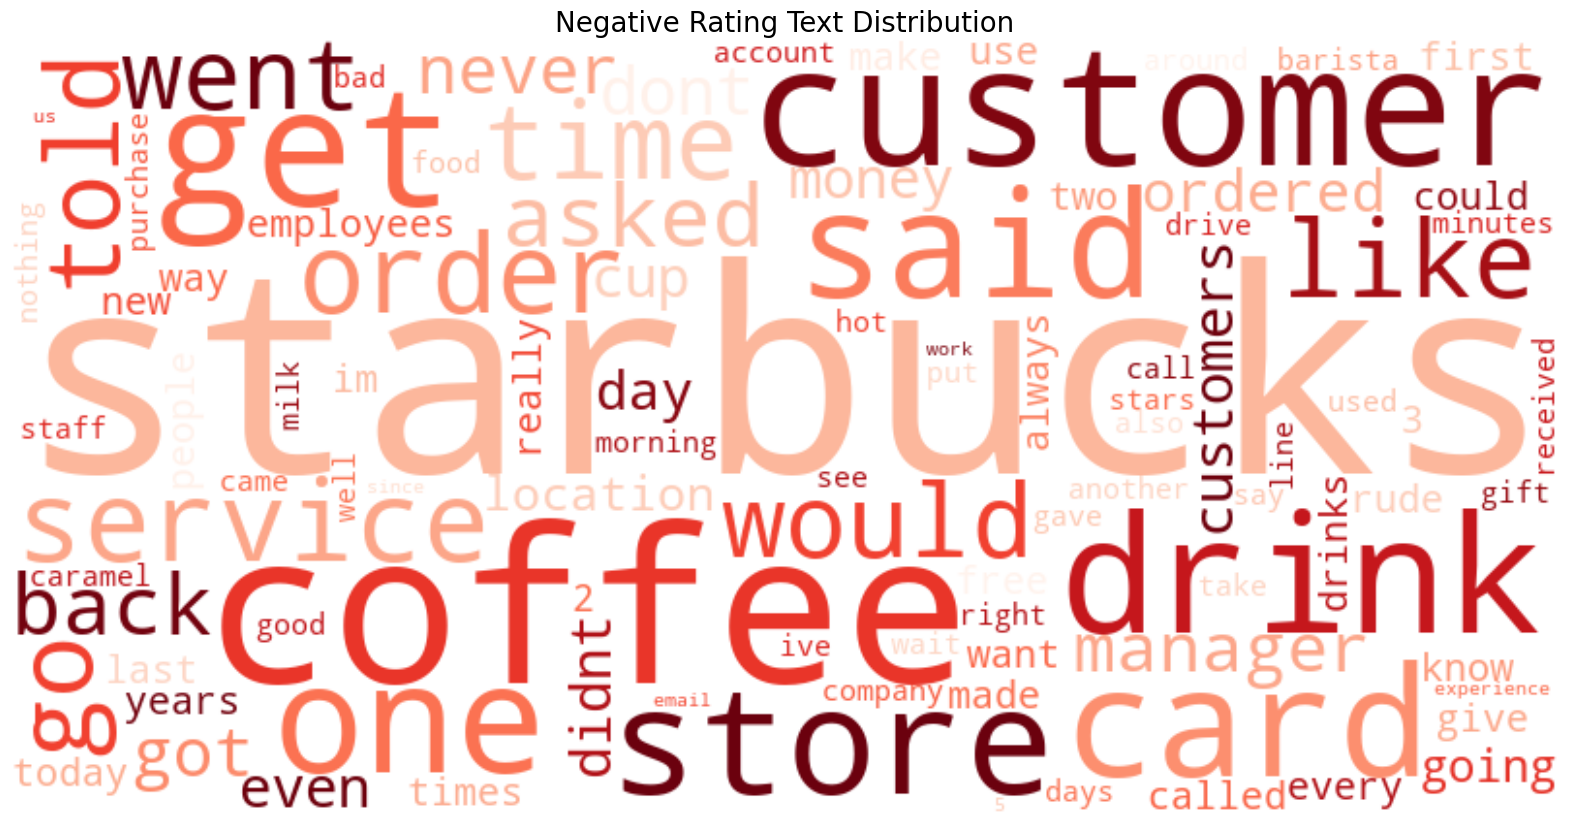

In [38]:
# Negative Words

negative_words = preprocess(df.loc[df['Rating'] == 'Negative']['Review'])
negative_words_df = create_freq_df(negative_words)
top10_negative_words = negative_words_df[:10]

plot_text_distribution(top10_negative_words['Term'], top10_negative_words['Frequency'],
                  'Reds', 'Top 10 Negative Rating Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(negative_words_df, 'Negative Rating Text Distribution', 'Reds')

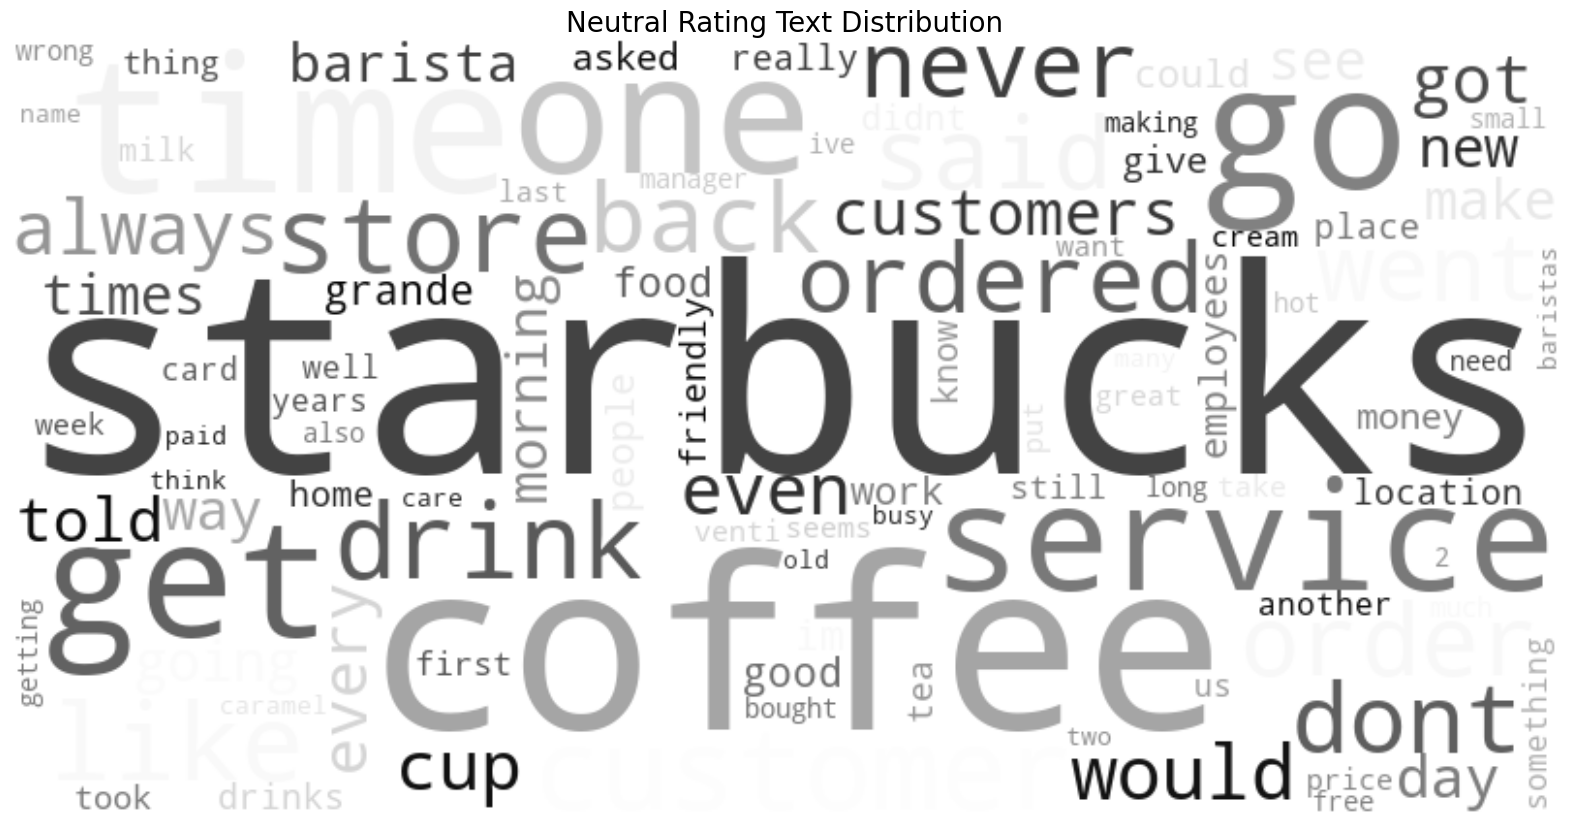

In [39]:
# Neutral Words

neutral_words = preprocess(df.loc[df['Rating'] == 'Neutral']['Review'])
neutral_words_df = create_freq_df(neutral_words)
top10_neutral_words = neutral_words_df[:10]

plot_text_distribution(top10_neutral_words['Term'], top10_neutral_words['Frequency'],
                  'Greys', 'Top 10 Neutral Rating Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(neutral_words_df, 'Neutral Rating Text Distribution', 'binary_r')

In [40]:
# Text preprocessing
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenization and lowercasing
    tokens = [token for token in tokens if token.isalpha()]  # Remove non-alphabetic tokens
    tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

sb_review['Preprocessed_Review'] = sb_review['Review'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91776\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [41]:
sb_review.head()

,Rating,Review,Preprocessed_Review
0,5.0,Amber and LaDonna at the Starbucks on Southwes...,amber ladonna starbucks southwest parkway alwa...
1,5.0,** at the Starbucks by the fire station on 436...,starbucks fire station altamonte springs fl ma...
2,5.0,I just wanted to go out of my way to recognize...,wanted go way recognize starbucks employee bil...
3,5.0,Me and my friend were at Starbucks and my card...,friend starbucks card work thankful worker pai...
4,5.0,I’m on this kick of drinking 5 cups of warm wa...,kick drinking cups warm water work instacart r...


In [42]:
# Text vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sb_review['Preprocessed_Review'])

In [44]:
# Clustering
num_clusters = 5  # Hypothetical number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Add cluster labels to the dataframe
sb_review['Cluster'] = kmeans.labels_

c:\Users\91776\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [45]:
sb_review.head()

,Rating,Review,Preprocessed_Review,Cluster
0,5.0,Amber and LaDonna at the Starbucks on Southwes...,amber ladonna starbucks southwest parkway alwa...,4
1,5.0,** at the Starbucks by the fire station on 436...,starbucks fire station altamonte springs fl ma...,0
2,5.0,I just wanted to go out of my way to recognize...,wanted go way recognize starbucks employee bil...,1
3,5.0,Me and my friend were at Starbucks and my card...,friend starbucks card work thankful worker pai...,3
4,5.0,I’m on this kick of drinking 5 cups of warm wa...,kick drinking cups warm water work instacart r...,3


In [46]:
# Sentiment analysis using TextBlob
def get_sentiment_textblob(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

sb_review['Sentiment_TextBlob'] = sb_review['Preprocessed_Review'].apply(get_sentiment_textblob)

In [47]:
# Sentiment analysis using VADER
def get_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    return scores['compound']

sb_review['Sentiment_VADER'] = sb_review['Preprocessed_Review'].apply(get_sentiment_vader)

In [48]:
sb_review.head(10)

,Rating,Review,Preprocessed_Review,Cluster,Sentiment_TextBlob,Sentiment_VADER
0,5.0,Amber and LaDonna at the Starbucks on Southwes...,amber ladonna starbucks southwest parkway alwa...,4,0.314286,0.8779
1,5.0,** at the Starbucks by the fire station on 436...,starbucks fire station altamonte springs fl ma...,0,0.393939,0.9670
2,5.0,I just wanted to go out of my way to recognize...,wanted go way recognize starbucks employee bil...,1,-0.140000,0.4215
3,5.0,Me and my friend were at Starbucks and my card...,friend starbucks card work thankful worker pai...,3,0.333333,0.9623
4,5.0,I’m on this kick of drinking 5 cups of warm wa...,kick drinking cups warm water work instacart r...,3,0.396561,0.9723
5,1.0,We had to correct them on our order 3 times. T...,correct order times never got right manager ca...,1,-0.071429,-0.8316
6,1.0,I have tried Starbucks several different times...,tried starbucks several different times differ...,1,0.000000,0.0000
7,1.0,Starbucks near me just launched new fall foods...,starbucks near launched new fall foods beverag...,4,0.151894,0.8885
8,1.0,"I ordered online for the Reisterstown Rd, St T...",ordered online reisterstown rd st thomas sc ga...,0,-0.500000,-0.8316
9,1.0,Staff at the Smythe St. Superstore location in...,staff smythe superstore location fredericton n...,1,-0.173810,-0.7655


In [49]:
# Analyze cluster labels
for cluster_label in range(num_clusters):
    print(f"Cluster {cluster_label}:")
    cluster_reviews = sb_review[sb_review['Cluster'] == cluster_label]['Review']
    print(f"Number of reviews: {len(cluster_reviews)}")
    
    # Sentiment analysis
    avg_sentiment_textblob = cluster_reviews.apply(get_sentiment_textblob).mean()
    avg_sentiment_vader = cluster_reviews.apply(get_sentiment_vader).mean()
    print(f"Average sentiment (TextBlob): {avg_sentiment_textblob}")
    print(f"Average sentiment (VADER): {avg_sentiment_vader}")
    
    # Most common words
    cluster_text = ' '.join(cluster_reviews)
    cluster_word_freq = pd.Series(cluster_text.split()).value_counts()
    print("Most common words:")
    print(cluster_word_freq.head(10))
    
    print("\n")

Cluster 0:
Number of reviews: 161
Average sentiment (TextBlob): -0.028108671577589756
Average sentiment (VADER): -0.21314782608695648
Most common words:
I      808
the    675
to     503
and    496
a      401
was    266
my     238
of     215
in     201
for    195
dtype: int64


Cluster 1:
Number of reviews: 183
Average sentiment (TextBlob): 0.013260350192319944
Average sentiment (VADER): -0.11339234972677592
Most common words:
the    717
I      614
and    541
to     520
a      356
was    227
in     223
of     203
my     188
at     163
dtype: int64


Cluster 2:
Number of reviews: 126
Average sentiment (TextBlob): 0.05512395406170698
Average sentiment (VADER): 0.11389603174603169
Most common words:
I            427
the          403
and          333
to           313
a            274
coffee       204
of           177
in           145
my           143
Starbucks    143
dtype: int64


Cluster 3:
Number of reviews: 97
Average sentiment (TextBlob): 0.03059391676427315
Average sentiment (VADER): 

TextBlob Sentiment Label:

Positive: Indicates that the sentiment of the text is positive. The polarity score is greater than 0.

Negative: Indicates that the sentiment of the text is negative. The polarity score is less than 0.

Neutral: Indicates that the sentiment of the text is neutral. The polarity score is close to 0

VADER Sentiment Label:

Positive: Indicates that the sentiment of the text is positive. The compound score is greater than 0.

Negative: Indicates that the sentiment of the text is negative. The compound score is less than 0.

Neutral: Indicates that the sentiment of the text is neutral. The compound score is close to 0.

In [50]:
sb_review

,Rating,Review,Preprocessed_Review,Cluster,Sentiment_TextBlob,Sentiment_VADER
0,5.0,Amber and LaDonna at the Starbucks on Southwes...,amber ladonna starbucks southwest parkway alwa...,4,0.314286,0.8779
1,5.0,** at the Starbucks by the fire station on 436...,starbucks fire station altamonte springs fl ma...,0,0.393939,0.9670
2,5.0,I just wanted to go out of my way to recognize...,wanted go way recognize starbucks employee bil...,1,-0.140000,0.4215
3,5.0,Me and my friend were at Starbucks and my card...,friend starbucks card work thankful worker pai...,3,0.333333,0.9623
4,5.0,I’m on this kick of drinking 5 cups of warm wa...,kick drinking cups warm water work instacart r...,3,0.396561,0.9723
...,...,...,...,...,...,...
700,1.0,I ordered Via Starbucks coffee online. I recei...,ordered via starbucks coffee online received e...,0,0.000000,-0.1779
701,3.0,"My name is Ric **, I am journalist by professi...",name ric journalist profession sending letter ...,2,-0.150000,-0.2960
702,1.0,"The bagel was ice cold, not cut and not toasted.",bagel ice cold cut toasted,1,-0.600000,-0.2732
703,1.0,"In the morning of Monday, August 15, 2011, at ...",morning monday august stopped starbucks buy us...,0,-0.116667,0.0000
